# Task 4

In [100]:
import cv2
from cv2 import imread, cvtColor, COLOR_BGR2RGB, COLOR_RGB2LAB, COLOR_LAB2RGB, split, createCLAHE, \
    merge, COLOR_RGB2BGR, PCACompute2, PCACompute, resize, COLOR_RGB2GRAY, namedWindow, WINDOW_AUTOSIZE, createTrackbar, \
    setMouseCallback, waitKey, destroyAllWindows, getTrackbarPos, WINDOW_NORMAL
from matplotlib.pyplot import figure, subplot, title, axis, imshow, tight_layout, show
from numpy import uint8, mgrid, sinc, exp, pi, double, zeros, abs, array, mean, float32, min, max, hstack, vstack, add, \
    reshape
from numpy.fft import fftshift, fft2, ifft2, ifftshift
from numpy.random import normal, rand
from sklearn.cluster import MiniBatchKMeans

In [101]:
def load(keyword, code=None):
    # read image by file
    # if code is 0 it reads the image with grayscale
    i =  imread('images/'+keyword+'.jpg', code)
    if i is None:
        i = imread('images/'+keyword+'.jpeg', code)
    if i is None:
        i = imread('images/'+keyword+'.tif', code)
    if i is None:
        print("Not found any ",keyword," jpg or jpeg")
    return i
def rgb(bgr):
    # convert bgr image to rgb
    return cvtColor(bgr, COLOR_BGR2RGB)
def show_images(name, images, desc=None, col=None, fig_size=(16, 9)):
    figure(figsize=fig_size)
    n = len(images)
    for k in range(0,n):
        img = images[k].astype(uint8)
        tit ="" if desc is None else name + " " + desc[k]
        if not col is None:
            c = col[k]
            subplot(1,n,k+1), title(tit), axis('off'), imshow(img,cmap=c)
        else :
            subplot(1,n,k+1), title(tit), axis('off'), imshow(img)
    tight_layout()
    show()
def add_gaussian_noise(img,mu=0.,sigma= 0.15):
    noise = normal(mu,sigma,img.shape) * 255
    return img + noise
def generate_variations(img):
    v1 = 255 - img
    v2 = quantize(img)
    v3 = add_gaussian_noise(img)
    v4 = enhance(img)
    v5 = diagonal_blur(img)
    gray = cvtColor(img,COLOR_RGB2GRAY)
    v6 = merge((gray,gray,gray))
    return array([img,v1,v2,v3,v4,v5,v6])
def quantize(img):
    m,n,_ = img.shape
    lab = cvtColor(img, COLOR_RGB2LAB)
    lab = lab.reshape((m*n, 3))
    clt = MiniBatchKMeans(n_clusters=8)
    labels = clt.fit_predict(lab)
    quantized = clt.cluster_centers_.astype(uint8)[labels]
    quantized = quantized.reshape((m,n,3))
    return cvtColor(quantized,COLOR_LAB2RGB)
def enhance(img):
    lab = cvtColor(img,COLOR_RGB2LAB)
    l,a,b = split(lab)
    clahe = createCLAHE(clipLimit=3.0, tileGridSize=(16,16))
    cl = clahe.apply(l)
    enhanced = merge((cl,a,b))
    return cvtColor(enhanced,COLOR_LAB2RGB)
def diagonal_blur(img, a=4, b=4):
    m,n,_ = img.shape
    [u, v] = mgrid[-m/2:m/2, -n/2:n/2]
    u = 2*u/m
    v = 2*v/n
    h = sinc((u*a) + (v*b)) * exp(-1j*pi*((u*a) + (v*b))).astype(double)
    g = zeros(img.shape, uint8)
    for k in range(0,img.shape[2]):
        c = img[:,:,k].astype(uint8)
        fc = fftshift(fft2(c)) * h
        g[:,:,k] = abs(ifft2(ifftshift(fc)))
    return g
def crop(img, k):
    #2048, 1536
    w,h,c = img.shape
    cw = w//6
    ch = h//4
    if k == 1:
        ch = h//8
        cropped= img[ch:-(3*ch), cw:-cw, :]
    else:
        cropped= img[ch:-ch, cw:-cw, :]
    return cropped

C:\Users\Lorenzo\AppData\Local\Temp/ipykernel_1060/2279186576.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  h = sinc((u*a) + (v*b)) * exp(-1j*pi*((u*a) + (v*b))).astype(double)
C:\Users\Lorenzo\AppData\Local\Temp/ipykernel_1060/2279186576.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  h = sinc((u*a) + (v*b)) * exp(-1j*pi*((u*a) + (v*b))).astype(double)
C:\Users\Lorenzo\AppData\Local\Temp/ipykernel_1060/2279186576.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  h = sinc((u*a) + (v*b)) * exp(-1j*pi*((u*a) + (v*b))).astype(double)


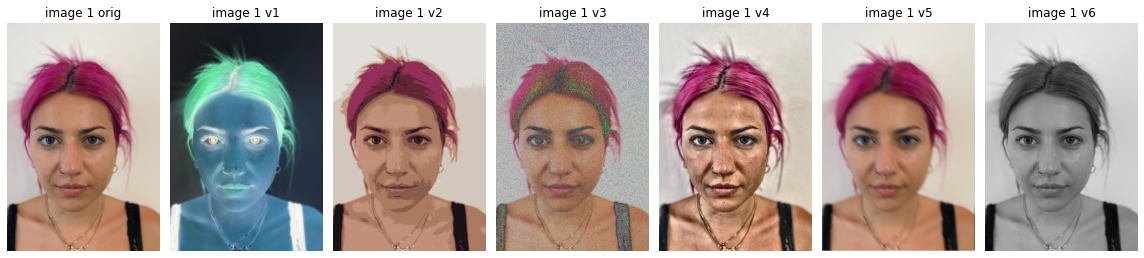

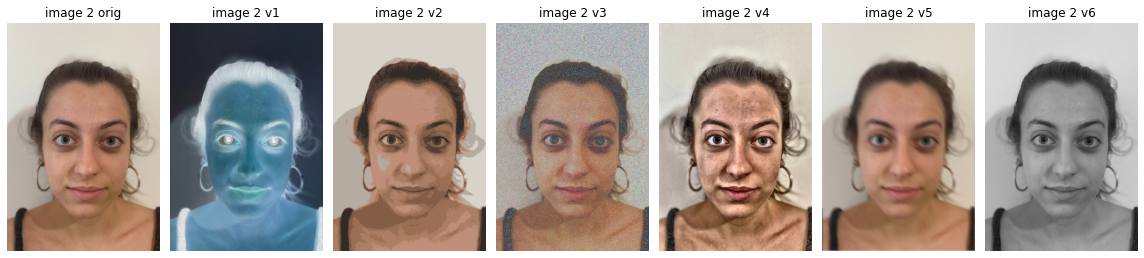

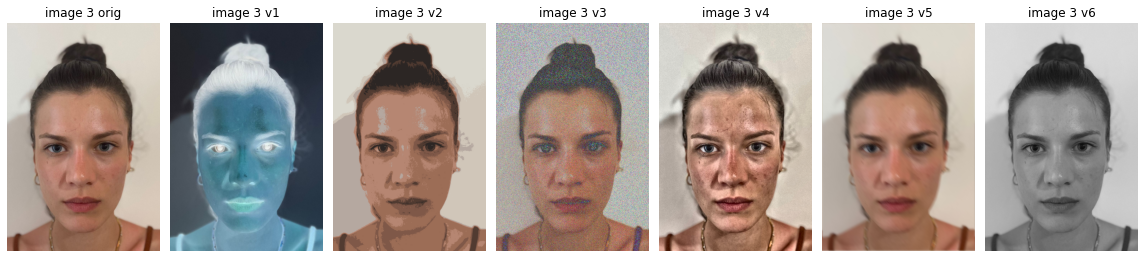

In [102]:
database = [
    generate_variations(
        crop(rgb(load("P1")),1)
    ),
    generate_variations(
        crop(rgb(load("P2")),0)
    ),
    generate_variations(
        crop(rgb(load("P3")),0)
    )
]

In [ ]:
for j in range(len(database)) :
    show_images("Person %d"%j, database[j] , ["orig","v1","v2","v3","v4","v5","v6"])

In [103]:
def flatten(db):
    people = len(db)
    images = len(db[0])
    m,n,c = (db[0][0]).shape
    data = zeros((people,images,m*n*c), dtype=float32)
    for k in range(people):
        person_images = db[k]
        for i in range(len(person_images)):
            flat = person_images[i].flatten()
            data[k,i,:] = flat
    return data, (m,n,c), people,images

In [104]:
database,image_size,num_people,num_images = flatten(database)

In [105]:
def compute_pca(db):
    N_images = vstack((db[0],db[1],db[2]))
    _mean, _eigenVectors = PCACompute(N_images,mean=mean(N_images,axis=0).reshape(1,-1),maxComponents=3)
    _averageFace = _mean.reshape(image_size)
    _eigenFaces = []
    l = len(_eigenVectors)

    figure(), imshow(_averageFace / 255), title("Average Face"), show()
    figure(figsize=(30,10))

    for h in range(l):
        eigenFace = (_eigenVectors[h] * 255).reshape(image_size)
        _eigenFaces.append(eigenFace)
        ef = eigenFace * 10
        subplot(1,l,h+1), imshow(ef, vmin=min(ef), vmax=max(ef)), axis('off'), title('EigenFace %d'%(h+1))

    tight_layout()
    show()

    return _averageFace, _eigenVectors, _eigenFaces

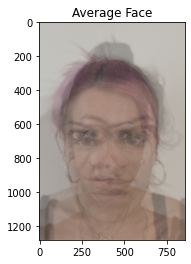

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


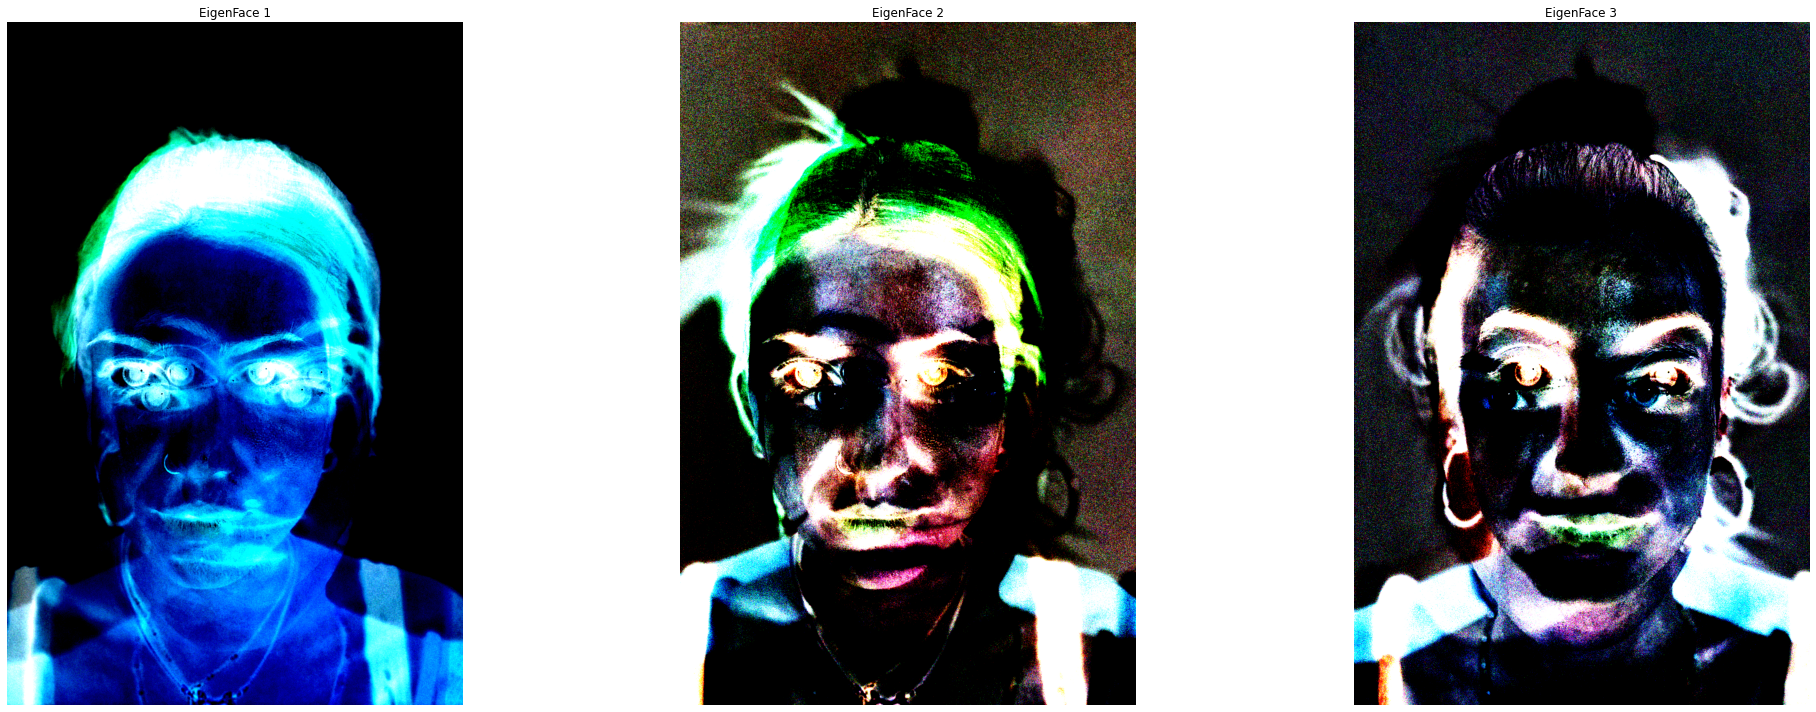

3


In [106]:
averageFace, eigenVectors, eigenFaces = compute_pca(database)
print(len(eigenFaces))

In [107]:
def reconstruct_face(_averageFace, _eigenFaces, weights=None):
    if weights is None:
        weights = [255, 255, 255]
    output = zeros(_averageFace.shape)

    if len(_eigenFaces.shape) > 3:
        for i in range(len(_eigenFaces)):
            output = add(output, _eigenFaces[i] * weights[i])
    else:
        output = add(output, _eigenFaces * weights[0])

    output = resize(output, (0,0), fx = 2, fy = 2)
    return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


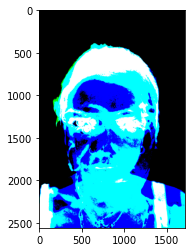

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


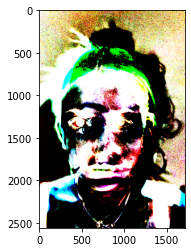

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


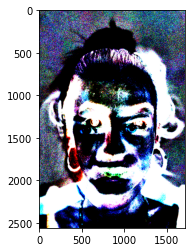

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


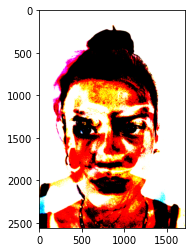

(<Figure size 432x288 with 1 Axes>,
 None)

In [108]:
for j in range(num_people):
    single = reconstruct_face(averageFace, array(eigenFaces[j]),[255])
    figure(), imshow(single), show()


combined = reconstruct_face(averageFace, array(eigenFaces),[-255,0,255])
figure(), imshow(combined), show()


In [109]:
def create_new_face(*args):
    out = averageFace

    for i in range(len(sliderValues)):
        sliderValues[i] = getTrackbarPos("W" + str(i), "Trackbars")
        weight = sliderValues[i] - MAX_SLIDER_VALUE//2
        out = add(out, eigenFaces[i] * weight)

    out = resize(out/255, (500,500), fx=2, fy=2)
    cv2.imshow("Result", out)

def reset_sliders(*args):
    for i in range(len(sliderValues)):
        sliderValues[i] = MAX_SLIDER_VALUE//2

In [110]:
MAX_SLIDER_VALUE = 255
namedWindow("Average",WINDOW_AUTOSIZE )
namedWindow("Result", WINDOW_AUTOSIZE)
output = resize(averageFace / 255 , (500,500), fx=2, fy=2)
cv2.imshow("Average", output)
cv2.imshow("Result", output)
namedWindow("Trackbars", WINDOW_AUTOSIZE)
sliderValues = []

for j in range(num_people):
    sliderValues.append(MAX_SLIDER_VALUE//2)
    createTrackbar("W" + str(j), "Trackbars", MAX_SLIDER_VALUE//2, MAX_SLIDER_VALUE, create_new_face)

setMouseCallback("Result", reset_sliders)
waitKey(0)
destroyAllWindows()